In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [27]:
# Fonction pour charger une image et déterminer si elle est en niveaux de gris ou RGB
def image_load(image_path, channel=None):
    assert os.path.exists(image_path), f"Erreur : Le chemin de l'image {image_path} n'existe pas"
    
    # Tenter de charger en niveaux de gris
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.imread(image_path)
    
    if channel == 1:
        assert gray_image is not None, "Erreur : Impossible de charger l'image en niveaux de gris"
        return gray_image, False
    elif channel == 3:
        assert rgb_image is not None, "Erreur : Impossible de charger l'image RGB"
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
        return rgb_image, True
    else:
        # Détection automatique
        if gray_image is not None and rgb_image is not None:
            # Vérifier si l'image est effectivement en niveaux de gris (canaux identiques)
            rgb_image_bgr = cv2.imread(image_path)  # Charger en BGR pour vérification
            if (rgb_image_bgr[:,:,0] == rgb_image_bgr[:,:,1]).all() and (rgb_image_bgr[:,:,1] == rgb_image_bgr[:,:,2]).all():
                return gray_image, False
            else:
                rgb_image = cv2.cvtColor(rgb_image_bgr, cv2.COLOR_BGR2RGB)
                return rgb_image, True
        elif gray_image is not None:
            return gray_image, False
        elif rgb_image is not None:
            rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
            return rgb_image, True
        else:
            raise AssertionError("Erreur : Impossible de charger l'image")

In [29]:
# Fonction pour appliquer la convolution sur un seul canal
def convolve_channel(image, kernel):
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy"
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy"
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D"
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré"
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire"
    assert image.shape[0] >= kernel.shape[0], "L'image est trop petite pour le noyau en hauteur"
    assert image.shape[1] >= kernel.shape[1], "L'image est trop petite pour le noyau en largeur"
    
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height, pad_width = kernel_height // 2, kernel_width // 2
    
    # Appliquer le padding
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    output = np.zeros_like(image, dtype=np.float32)
    
    # Effectuer la convolution
    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = np.sum(region * kernel)
    
    # Vérifier la taille de la sortie
    assert output.shape == image.shape, "La taille de la sortie ne correspond pas à la taille de l'image d'entrée"
    return output

In [31]:
# Fonction pour appliquer la convolution sur une image (niveaux de gris ou RGB)
def apply_convolution(image, kernel):
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy"
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy"
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D"
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré"
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire"
    assert len(image.shape) in [2, 3], "L'image doit être en niveaux de gris (2D) ou RGB (3D)"
    
    if len(image.shape) == 3:
        assert image.shape[2] == 3, "L'image RGB doit avoir 3 canaux"
        height, width, channels = image.shape
        output = np.zeros_like(image, dtype=np.float32)
        for c in range(channels):
            output[:, :, c] = convolve_channel(image[:, :, c], kernel)
    else:
        output = convolve_channel(image, kernel)
    
    # Normaliser la sortie à [0, 255]
    output = np.clip(output, 0, 255).astype(np.uint8)
    assert output.shape == image.shape, "La taille de la sortie ne correspond pas à la taille de l'image d'entrée"
    return output

In [33]:
# Fonction pour afficher plusieurs images dans une seule figure
def display_images(images, titles, is_rgb):
    assert len(images) == len(titles), "Le nombre d'images doit correspondre au nombre de titres"
    
    n = len(images)
    plt.figure(figsize=(5 * n, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap='gray' if not is_rgb else None)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [35]:
# Définir les noyaux de convolution

In [45]:
# Noyaux de flou
blur_3x3 = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
])

In [39]:
blur_5x5 = np.array([
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25]
])

In [41]:
blur_7x7 = np.ones((7, 7)) / 49

In [47]:
# Noyaux Sobel
sobel_horizontal = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

In [49]:
sobel_vertical = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

In [51]:
# Noyau de netteté
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

In [53]:
# Noyaux aléatoires avec graine fixe
np.random.seed(42)
random_3x3 = np.random.rand(3, 3)
random_3x3 /= random_3x3.sum()  # Normaliser pour que la somme soit 1
random_5x5 = np.random.rand(5, 5)
random_5x5 /= random_5x5.sum()
random_7x7 = np.random.rand(7, 7)
random_7x7 /= random_7x7.sum()

In [55]:
# Noyaux supplémentaires (par exemple, détection de contours, Laplacien)
edge_detection = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

laplacian = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])

In [57]:
# Fonction principale de traitement
def process_image(image_path):
    # Charger l'image
    image, is_rgb = image_load(image_path)
    
    # Définir les filtres
    filters = [
        (blur_3x3, "Flou 3x3"),
        (blur_5x5, "Flou 5x5"),
        (blur_7x7, "Flou 7x7"),
        (sobel_horizontal, "Sobel Horizontal"),
        (sobel_vertical, "Sobel Vertical"),
        (sharpen, "Netteté"),
        (edge_detection, "Détection de Contours"),
        (laplacian, "Laplacien"),
        (random_3x3, "Aléatoire 3x3"),
        (random_5x5, "Aléatoire 5x5"),
        (random_7x7, "Aléatoire 7x7")
    ]
    
    # Appliquer les filtres et collecter les résultats
    filtered_images = [image]
    titles = ["Original"]
    
    for kernel, name in filters:
        filtered = apply_convolution(image, kernel)
        filtered_images.append(filtered)
        titles.append(name)
        
        # Sauvegarder l'image filtrée
        if is_rgb:
            cv2.imwrite(f"{name.lower().replace(' ', '_')}_rgb.jpg", cv2.cvtColor(filtered, cv2.COLOR_RGB2BGR))
        else:
            cv2.imwrite(f"{name.lower().replace(' ', '_')}_gray.jpg", filtered)
    
    # Afficher toutes les images
    display_images(filtered_images, titles, is_rgb)

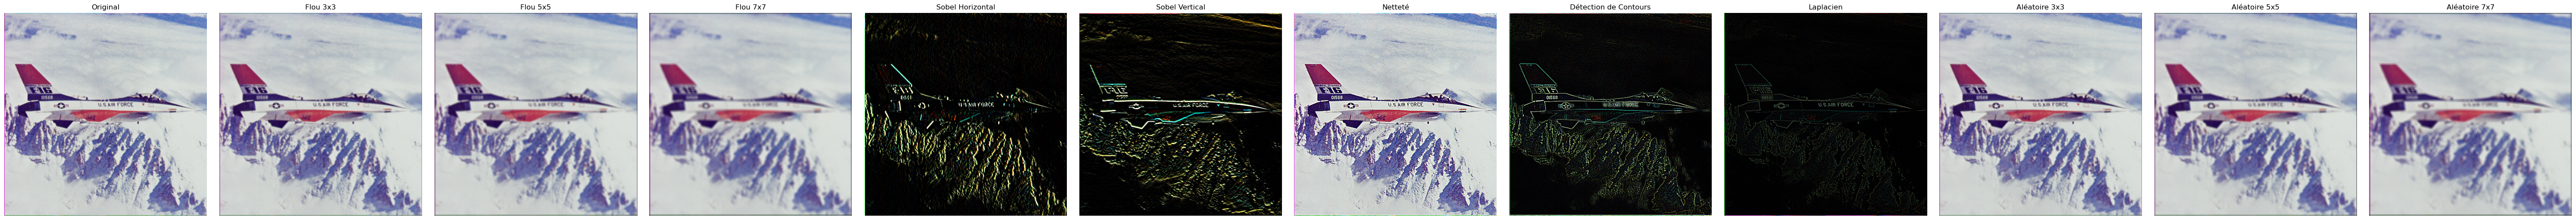

In [64]:
# Exemple d'utilisation
if __name__ == "__main__":
    # Remplacer par le chemin d'une image de https://www.hlevkin.com/hlevkin/06testimages.htm
    image_path = "airplane.bmp"  # Assurez-vous que l'image est dans le dossier du script
    process_image(image_path)

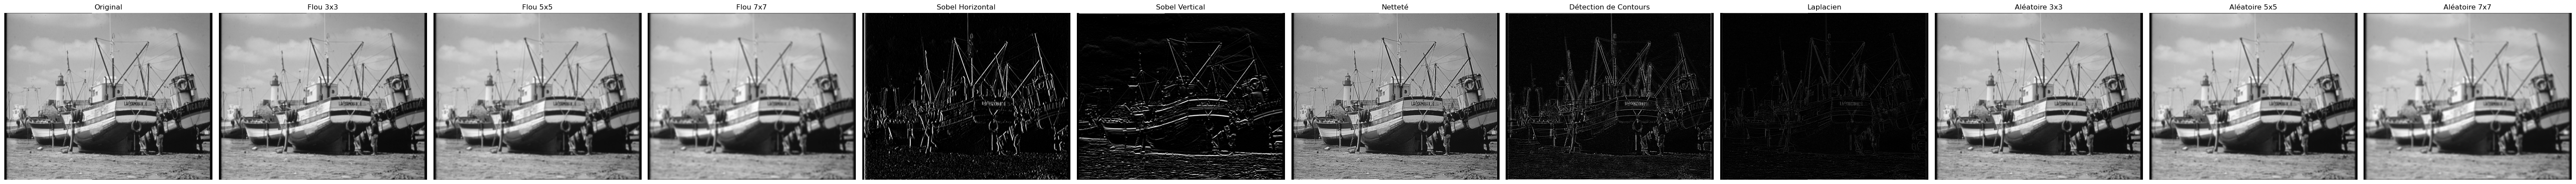

In [66]:
# Exemple d'utilisation
if __name__ == "__main__":
    # Remplacer par le chemin d'une image de https://www.hlevkin.com/hlevkin/06testimages.htm
    image_path = "boats.bmp"  # Assurez-vous que l'image est dans le dossier du script
    process_image(image_path)